In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re as re
import seaborn as sns

In [2]:
train = pd.read_csv('train.csv')
print(train.isnull().sum()/len(train)*100)
train.head()
test = pd.read_csv('test.csv')
print(test.isnull().sum()/len(test)*100)
data = train.drop('Survived', axis=1).append(test)
data.head()

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64
PassengerId     0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            20.574163
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.239234
Cabin          78.229665
Embarked        0.000000
dtype: float64


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
i = 0
for name, obj in train[['Survived', 'Name', 'Ticket']].groupby('Ticket', as_index=False):
    if (len(obj)>1):
        print(name)
        print('\t')
        print(obj)
        print(obj.Survived.mean())
        print('-' * 10)

110152
	
     Survived                                               Name  Ticket
257         1                               Cherry, Miss. Gladys  110152
504         1                              Maioni, Miss. Roberta  110152
759         1  Rothes, the Countess. of (Lucy Noel Martha Dye...  110152
1.0
----------
110413
	
     Survived                                    Name  Ticket
262         0                       Taussig, Mr. Emil  110413
558         1  Taussig, Mrs. Emil (Tillie Mandelbaum)  110413
585         1                     Taussig, Miss. Ruth  110413
0.6666666666666666
----------
110465
	
     Survived                            Name  Ticket
110         0  Porter, Mr. Walter Chamberlain  110465
475         0     Clifford, Mr. George Quincy  110465
0.0
----------
111361
	
     Survived                                             Name  Ticket
329         1                     Hippach, Miss. Jean Gertrude  111361
523         1  Hippach, Mrs. Louis Albert (Ida Sophia Fische

     Survived                                          Name    Ticket
309         1                Francatelli, Miss. Laura Mabel  PC 17485
599         1  Duff Gordon, Sir. Cosmo Edmund ("Mr Morgan")  PC 17485
1.0
----------
PC 17558
	
     Survived                                             Name    Ticket
118         0                         Baxter, Mr. Quigg Edmond  PC 17558
299         1  Baxter, Mrs. James (Helene DeLaudeniere Chaput)  PC 17558
0.5
----------
PC 17569
	
     Survived                                            Name    Ticket
31          1  Spencer, Mrs. William Augustus (Marie Eugenie)  PC 17569
195         1                            Lurette, Miss. Elise  PC 17569
1.0
----------
PC 17572
	
     Survived                                      Name    Ticket
52          1  Harper, Mrs. Henry Sleeper (Myna Haxtun)  PC 17572
645         1                 Harper, Mr. Henry Sleeper  PC 17572
681         1                        Hassab, Mr. Hammad  PC 17572
1.0
---------

In [8]:
data['Group_survived'] = -1
data['Has_group'] = 0
for name, obj in train[['Survived', 'Name', 'Ticket']].groupby('Ticket', as_index=False):
    if (len(obj) > 1):
        data.loc[data['Ticket']==name, 'Group_survived'] = obj['Survived'].mean()
        data.loc[data['Ticket']==name, 'Has_group'] = 1

train['Group_survived'] = data['Group_survived'][:891]
test['Group_survived'] = data['Group_survived'][891:]
train['Has_group'] = data['Has_group'][:891]
test['Has_group'] = data['Has_group'][891:]
#test['Has_group'].fillna(data['Group_survived'].mean(), inplace=True)
print(train.head())
print(test.head())
print(train[['Group_survived', 'Survived']].groupby('Group_survived', as_index=False).mean())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  Group_survived  Has_group  
0      0         A/5 21171   7.2500   NaN        S            -1.0          0  
1      0          PC 17599  71.2833   C85        C            -1.0          0  
2      0  STON/O2. 3101282   7.9250   NaN        S            -1.0          0  


In [24]:
data['Survived'] = -1
data['Survived'][:891] = train['Survived']
for name, obj in data[['Survived', 'PassengerId', 'Name', 'Ticket', 'Group_survived']].groupby('Ticket'):
    if (len(obj)>1) & (obj['Survived'].mean()==-1):
        print(name)
        print('\t')
        print(obj)
        print('-' * 10)

/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


112378
	
     Survived  PassengerId                                     Name  Ticket  \
368        -1         1260  Gibson, Mrs. Leonard (Pauline C Boeson)  112378   
402        -1         1294           Gibson, Miss. Dorothy Winifred  112378   

     Group_survived  
368            -1.0  
402            -1.0  
----------
11778
	
     Survived  PassengerId                                               Name  \
100        -1          992  Stengel, Mrs. Charles Emil Henry (Annie May Mo...   
177        -1         1069                    Stengel, Mr. Charles Emil Henry   

    Ticket  Group_survived  
100  11778            -1.0  
177  11778            -1.0  
----------
13050
	
     Survived  PassengerId                          Name Ticket  \
118        -1         1010          Beattie, Mr. Thomson  13050   
270        -1         1162  McCaffry, Mr. Thomas Francis  13050   

     Group_survived  
118            -1.0  
270            -1.0  
----------
13236
	
     Survived  PassengerId     

In [7]:
train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Has_group
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658,-0.003890
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,0.222602
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500,-0.212908
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,-0.181341
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,0.441524
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,0.471392
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,0.432684
Has_group,-0.003890,0.222602,-0.212908,-0.181341,0.441524,0.471392,0.432684,1.000000


In [13]:
X_train_group = train.loc[train['Has_group']==1].drop('Has_group', axis=1).copy()
X_train_nogroup = train.loc[train['Has_group']==0].drop(['Has_group', 'Group_survived'], axis=1).copy()

X_test_group = test.loc[(test['Has_group']==1) & ((test['Group_survived'] >= 0)| (test['Sex']=='male'))].drop('Has_group', axis=1).copy()
X_test_nogroup = test.loc[(test['Has_group']==0) | (test['Sex']=='female') & (test['Group_survived'] < 0)].drop(['Has_group', 'Group_survived'], axis=1).copy()

print(X_train_group.head())
print('-'*10)
print(X_train_nogroup.head())
print('-'*10)
print(X_test_group.head())
print('-'*10)
print(X_test_nogroup.head())
print('-'*10)
print(len(X_test_group) + len(X_test_nogroup) == len(test))

    PassengerId  Survived  Pclass  \
3             4         1       1   
7             8         0       3   
8             9         1       3   
9            10         1       2   
10           11         1       3   

                                                 Name     Sex   Age  SibSp  \
3        Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
7                      Palsson, Master. Gosta Leonard    male   2.0      3   
8   Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)  female  27.0      0   
9                 Nasser, Mrs. Nicholas (Adele Achem)  female  14.0      1   
10                    Sandstrom, Miss. Marguerite Rut  female   4.0      1   

    Parch   Ticket     Fare Cabin Embarked  Group_survived  
3       0   113803  53.1000  C123        S             0.5  
7       1   349909  21.0750   NaN        S             0.0  
8       2   347742  11.1333   NaN        S             1.0  
9       0   237736  30.0708   NaN        C             0.5  
10 

In [15]:
# OBTAIN SET OF LABELS
Y_train_group = X_train_group['Survived']
Y_train_nogroup = X_train_nogroup['Survived']
print(Y_train_group[:10])
print(Y_train_nogroup[:10])
X_train_group.drop('Survived', axis=1, inplace=True)
X_train_nogroup.drop('Survived', axis=1, inplace=True)
print(X_train_group[:10])
print(X_train_nogroup[:10])

3     1
7     0
8     1
9     1
10    1
13    0
16    0
20    0
24    0
25    1
Name: Survived, dtype: int64
0     0
1     1
2     1
4     0
5     0
6     0
11    1
12    0
14    0
15    1
Name: Survived, dtype: int64
    PassengerId  Pclass                                               Name  \
3             4       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
7             8       3                     Palsson, Master. Gosta Leonard   
8             9       3  Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)   
9            10       2                Nasser, Mrs. Nicholas (Adele Achem)   
10           11       3                    Sandstrom, Miss. Marguerite Rut   
13           14       3                        Andersson, Mr. Anders Johan   
16           17       3                               Rice, Master. Eugene   
20           21       2                               Fynney, Mr. Joseph J   
24           25       3                      Palsson, Miss. Torborg Danira   
25

In [4]:
# FILL NAN VALUES
# FILL AGE
meanAge = data.Age.mean()
stdAge = data.Age.std()

def fillAge(df, meanAge, stdAge):
    ageNullCount = df.Age.isnull().sum()
    
    randomAgeArray = np.random.randint(meanAge - stdAge, meanAge + stdAge, size=ageNullCount)
    
    df['Age'][np.isnan(df['Age'])] = randomAgeArray
    df['Age'] = df['Age'].astype(int)
    
    return df

data = fillAge(train, meanAge, stdAge)
train = data[:891]
test = data[:891]

/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [5]:
print(train.isnull().sum()/len(train)*100)
print(test.isnull().sum()/len(test)*100)

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age             0.000000
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64
PassengerId     0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age             0.000000
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.239234
Cabin          78.229665
Embarked        0.000000
dtype: float64


In [6]:
# FILL FARES
print(train[['Fare', 'Pclass']].groupby('Pclass', as_index=False).median())
print(train[['Fare', 'Pclass']].groupby('Pclass', as_index=False).describe())

   Pclass     Fare
0       1  60.2875
1       2  14.2500
2       3   8.0500
    Fare                                                               Pclass  \
   count       mean        std  min       25%      50%   75%       max  count   
0  216.0  84.154687  78.380373  0.0  30.92395  60.2875  93.5  512.3292  216.0   
1  184.0  20.662183  13.417399  0.0  13.00000  14.2500  26.0   73.5000  184.0   
2  491.0  13.675550  11.778142  0.0   7.75000   8.0500  15.5   69.5500  491.0   

                                      
  mean  std  min  25%  50%  75%  max  
0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  
1  2.0  0.0  2.0  2.0  2.0  2.0  2.0  
2  3.0  0.0  3.0  3.0  3.0  3.0  3.0  


In [7]:
print(test[['Fare', 'Pclass']].groupby('Pclass', as_index=False).describe())

# only missing value is from third class
np.random.seed(42)
test.Fare = test.Fare.fillna(11.778142 * np.random.rand() + 13.67555) #fill by randomly generating a number in distribution with mean and std from training set
print(test.isnull().sum()/len(test)*100)

    Fare                                                                 \
   count       mean        std     min    25%      50%    75%       max   
0  107.0  94.280297  84.435858  0.0000  30.10  60.0000  134.5  512.3292   
1   93.0  22.202104  13.991877  9.6875  13.00  15.7500   26.0   73.5000   
2  217.0  12.459678  10.803698  3.1708   7.75   7.8958   14.4   69.5500   

  Pclass                                     
   count mean  std  min  25%  50%  75%  max  
0  107.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  
1   93.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0  
2  218.0  3.0  0.0  3.0  3.0  3.0  3.0  3.0  
PassengerId     0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age             0.000000
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          78.229665
Embarked        0.000000
dtype: float64


In [8]:
# FILL CABIN
train.Cabin = train.Cabin.fillna('U')
test.Cabin = test.Cabin.fillna('U')

print(train.isnull().sum()/len(train)*100)
print(test.isnull().sum()/len(test)*100)

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.000000
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.000000
Embarked       0.224467
dtype: float64
PassengerId    0.0
Pclass         0.0
Name           0.0
Sex            0.0
Age            0.0
SibSp          0.0
Parch          0.0
Ticket         0.0
Fare           0.0
Cabin          0.0
Embarked       0.0
dtype: float64


In [9]:
# FILL EMBARKED
# MODE IS 'S'
train.Embarked = train.Embarked.fillna('S')
print(train.isnull().sum()/len(train)*100)

PassengerId    0.0
Survived       0.0
Pclass         0.0
Name           0.0
Sex            0.0
Age            0.0
SibSp          0.0
Parch          0.0
Ticket         0.0
Fare           0.0
Cabin          0.0
Embarked       0.0
dtype: float64


In [10]:
# FEATURE ENGINEERING
# 1. Name
# Need to extract titles
def extractTitles(name):
    title = re.search(' ([A-Za-z]+)\.', name)
    if title:
        return title.group(1)
    return ""

train['Title'] = train['Name'].apply(extractTitles)
test['Title'] = test['Name'].apply(extractTitles)
    
print(train.Title.unique())
print(test.Title.unique())

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'Countess' 'Jonkheer']
['Mr' 'Mrs' 'Miss' 'Master' 'Ms' 'Col' 'Rev' 'Dr' 'Dona']


In [11]:
# Clean up titles
print(pd.crosstab(train.Title, train.Sex))

def cleanTitle(df):
    df.Title = df.Title.replace(['Capt', 'Col', 'Countess', 'Don', 'Dona', 'Dr', 'Jonkheer', 'Lady', 'Major', 'Rev', 'Sir'], 'Rare')
    df.Title = df.Title.replace(['Ms', 'Mlle'], 'Miss')
    df.Title = df.Title.replace('Mme', 'Mrs')
    
    return df

train = cleanTitle(train)
test = cleanTitle(test)
    
print(train.Title.unique())
print(test.Title.unique())

Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         182     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          125     0
Ms             1     0
Rev            0     6
Sir            0     1
['Mr' 'Mrs' 'Miss' 'Master' 'Rare']
['Mr' 'Mrs' 'Miss' 'Master' 'Rare']


In [12]:
# See how title affects survival
print(train[['Title', 'Survived']].groupby('Title', as_index=False).mean())

    Title  Survived
0  Master  0.575000
1    Miss  0.702703
2      Mr  0.156673
3     Mrs  0.793651
4    Rare  0.347826


In [13]:
# 2. Whether alone or with family
def isNotAlone(df):
    df['IsNotAlone'] = 1
    df.loc[df['SibSp'] + df['Parch'] == 0, 'IsNotAlone'] = 0
    
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    
    return df

train = isNotAlone(train)
test = isNotAlone(test)

print(train[['IsNotAlone', 'Survived']].groupby('IsNotAlone', as_index=False).mean())

   IsNotAlone  Survived
0           0  0.303538
1           1  0.505650


In [14]:
# 3. Whether has a cabin or not
def hasCabin(df):
    df['HasCabin'] = 1
    df.loc[df['Cabin']=='U', 'HasCabin'] = 0
    
    return df

train = hasCabin(train)
test = hasCabin(test)
    
print(train[['HasCabin', 'Survived']].groupby('HasCabin', as_index=False).mean())

   HasCabin  Survived
0         0  0.299854
1         1  0.666667


In [15]:
# 4. Sex matters
print(train[['Sex', 'Survived']].groupby('Sex', as_index=False).mean())

      Sex  Survived
0  female  0.742038
1    male  0.188908


In [16]:
# 5. Age matters
train['CategoricalAge'] = pd.qcut(train['Age'], 5)
print(train[['CategoricalAge', 'Survived']].groupby('CategoricalAge', as_index=False).mean())

   CategoricalAge  Survived
0  (-0.001, 19.0]  0.467005
1    (19.0, 25.0]  0.307692
2    (25.0, 32.0]  0.378238
3    (32.0, 40.0]  0.390244
4    (40.0, 80.0]  0.363095


In [17]:
# 6. Where they embarked from
print(train[['Embarked', 'Survived']].groupby('Embarked', as_index=False).mean())

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009


In [18]:
# 7. Class
print(train[['Pclass', 'Survived']].groupby('Pclass', as_index=False).mean())

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


In [19]:
# 8. Fare
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
print(train[['CategoricalFare', 'Survived']].groupby('CategoricalFare', as_index=False).mean())

   CategoricalFare  Survived
0   (-0.001, 7.91]  0.197309
1   (7.91, 14.454]  0.303571
2   (14.454, 31.0]  0.454955
3  (31.0, 512.329]  0.581081


In [20]:
train = train.drop(['CategoricalFare', 'CategoricalAge'], axis=1) # drop dummy columns
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,IsNotAlone,FamilySize,HasCabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,U,S,Mr,1,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,Mrs,1,2,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,U,S,Miss,0,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,Mrs,1,2,1
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,U,S,Mr,0,1,0


In [21]:
# process data for training
def process(df):
    # remove unneccessary columns
    dropColumns = ['PassengerId', 'SibSp', 'Parch', 'Name', 'Ticket', 'Cabin']
    df = df.drop(dropColumns, axis=1)
    print(df.columns)
    
    # map title column
    titleMapping = {'Mr':0, 'Rare':1, 'Master':2, 'Miss':3, 'Mrs':4}
    df.Title = df.Title.map(titleMapping)
    
    # map sex column
    sexMapping = {'male':0, 'female':1}
    df.Sex = df.Sex.map(sexMapping)
    
    # map age column
    
    df.loc[df['Age'] <= 19, 'Age'] = 4
    df.loc[(df['Age'] > 19) & (df['Age'] <= 25), 'Age'] = 0
    df.loc[df['Age'] > 40, 'Age'] = 1
    df.loc[(df['Age'] > 32) & (df['Age'] <= 40), 'Age'] = 2
    df.loc[(df['Age'] > 25) & (df['Age'] <= 32), 'Age'] = 3
    
    # map fare column
    df.loc[df['Fare'] <= 7.91, 'Fare'] = 0
    df.loc[(df['Fare'] > 7.91) & (df['Fare'] <= 14.454), 'Fare'] = 1
    df.loc[(df['Fare'] > 14.454) & (df['Fare'] <= 31.0), 'Fare'] = 2
    df.loc[df['Fare'] > 31.0, 'Fare'] = 3
    
    # map embarked column
    embarkedMapping = {'S':0, 'Q':1, 'C':2}
    df.Embarked = df.Embarked.map(embarkedMapping)
    
    print(df.head())
    
    return df

train = process(train)
test = process(test)

Index(['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Title',
       'IsNotAlone', 'FamilySize', 'HasCabin'],
      dtype='object')
   Survived  Pclass  Sex  Age  Fare  Embarked  Title  IsNotAlone  FamilySize  \
0         0       3    0    0   0.0         0      0           1           2   
1         1       1    1    2   3.0         2      4           1           2   
2         1       3    1    3   1.0         0      3           0           1   
3         1       1    1    2   3.0         0      4           1           2   
4         0       3    0    2   1.0         0      0           0           1   

   HasCabin  
0         0  
1         1  
2         0  
3         1  
4         0  
Index(['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Title', 'IsNotAlone',
       'FamilySize', 'HasCabin'],
      dtype='object')
   Pclass  Sex  Age  Fare  Embarked  Title  IsNotAlone  FamilySize  HasCabin
0       3    0    2   0.0         1      0           0           1         0
1       3

In [22]:
train.to_csv('processed_train.csv', index=False)
test.to_csv('processed_test.csv', index=False)

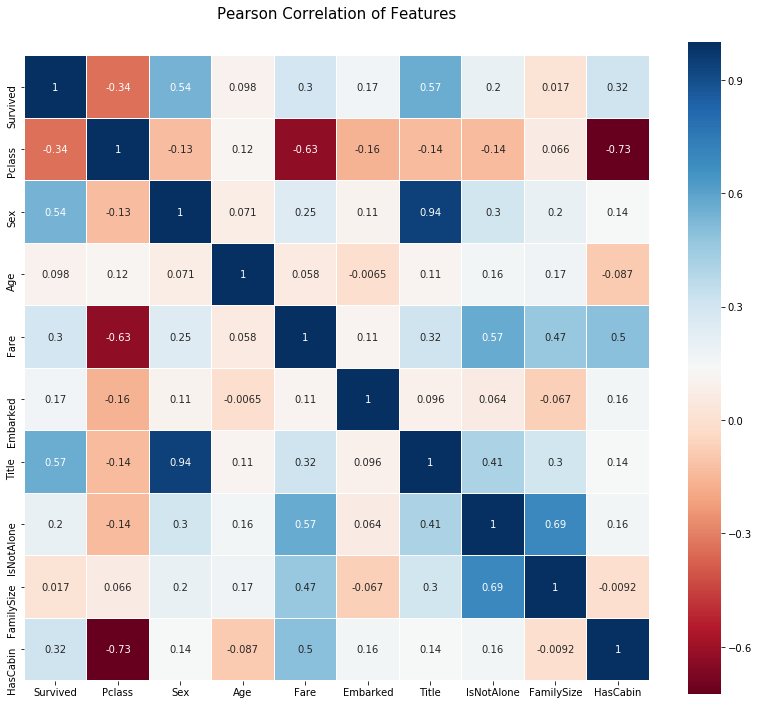

In [23]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)